# Purpose:
- To test the efficacy of online motion correction with one plane in the middle.
- Mostly copying from qc/2p_data/z_drift/240222_multiplane_zdrift_comparison.ipynb


In [3]:
import brain_observatory_qc.pipeline_dev.scripts.depth_estimation_module as dem
from pathlib import Path
import numpy as np
import pandas as pd
import h5py
from datetime import datetime
from matplotlib import pyplot as plt
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache as bpc
from brain_observatory_qc.data_access import from_lims
from pymongo import MongoClient
import sys
sys.path.append(r'C:\Users\jinho.kim\Github\visual_behavior_analysis')
from visual_behavior import database as db

mongo = MongoClient('flaskapp.corp.alleninstitute.org', 27017)

save_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')

In [4]:
def get_depth_region_from_db(oeid):
    query = '''
    SELECT oe.id, st.acronym, oe.calculated_depth, imd.depth
    FROM ophys_experiments oe
    JOIN structures st ON st.id = oe.targeted_structure_id
    JOIN imaging_depths imd ON imd.id = oe.imaging_depth_id
    WHERE oe.id = {}
    '''.format(oeid)
    lims_results = db.lims_query(query)
    return lims_results.depth.values[0], lims_results.acronym.values[0]


def get_zdrift_results(osid, load_dir):
    oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
    corrcoef = []
    matched_plane_indices = []
    for oeid in oeids:
        try:
            ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
        except:
            ocid = 'none'
        zdrift_fn = load_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}.h5'
        
        with h5py.File(zdrift_fn) as h:
            corrcoef.append([np.max(cc) for cc in h['corrcoef'][:]])
            matched_plane_indices.append(h['matched_plane_indices'][:])
    return corrcoef, matched_plane_indices, oeids

def get_zdrift_results_first_last(osid, load_dir):
    oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
    corrcoef = []
    matched_plane_indices = []
    for oeid in oeids:
        try:
            ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
        except:
            ocid = 'none'
        zdrift_fn = load_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}_first_last.h5'
        with h5py.File(zdrift_fn) as h:
            corrcoef.append([np.max(cc) for cc in h['corrcoef'][:]])
            matched_plane_indices.append(h['matched_plane_indices'][:])
    return corrcoef, matched_plane_indices, oeids


In [ ]:
# lamf_table = table.query('project_code == "LearningmFISHTask1A"')

In [5]:
# Loading processed data table
load_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
multiplane_zdrift_osids = pd.read_csv(load_dir / 'multiplane_zdrift_osids_240223.csv')
multiplane_zdrift_osids.head()

,mouse_id,ophys_session_id,config,session_type
0,629294,1190857914,4x2,TRAINING_3_images_A_10uL_reward
1,629294,1192836327,4x2,OPHYS_4_images_B
2,629294,1192643624,4x2,OPHYS_1_images_A
3,633532,1198731689,4x2,TRAINING_1_gratings
4,633532,1202354311,4x2,OPHYS_4_images_B


## Testing in one sample

In [6]:
osid = 1243753586
corrcoef, matched_plane_indices, oeids = get_zdrift_results_first_last(osid, load_dir)

In [9]:
depths = []
for oeid in oeids:
    # try:
    #     current_depth = lamf_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0]
    # except:
    current_depth, current_region = get_depth_region_from_db(oeid)
    depths.append(current_depth)

C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pan

In [34]:
mid_plane_ind = np.argsort(depths)[4]
local_zstack_interval = 0.75
zdrift = local_zstack_interval * np.array([mpi[1] - mpi[0] for mpi in matched_plane_indices])
corrected_zdrift = zdrift - zdrift[mid_plane_ind]


Text(0, 0.5, 'abs(corrected zdrift) (um)')

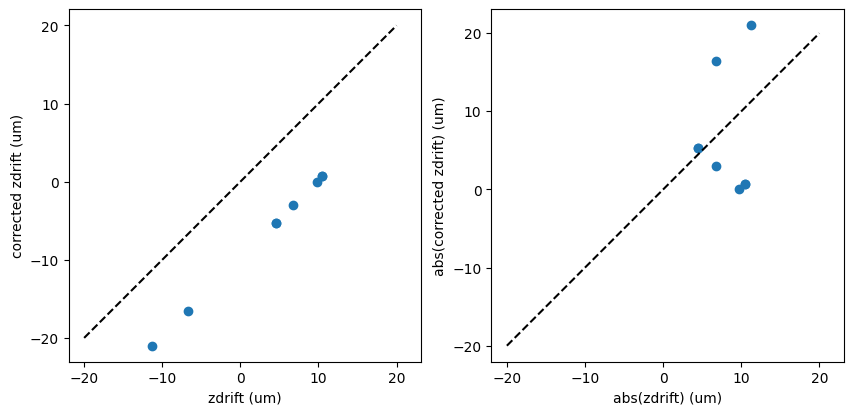

In [35]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter((zdrift), (corrected_zdrift))
ax[0].plot([-20, 20], [-20, 20], 'k--')
ax[0].axis('square')
ax[0].set_xlabel('zdrift (um)')
ax[0].set_ylabel('corrected zdrift (um)')
ax[1].scatter(abs(zdrift), abs(corrected_zdrift))
ax[1].plot([-20, 20], [-20, 20], 'k--')
ax[1].axis('square')
ax[1].set_xlabel('abs(zdrift) (um)')
ax[1].set_ylabel('abs(corrected zdrift) (um)')

## All 1x8 data

In [46]:
cache = bpc.from_lims()
table = cache.get_ophys_experiment_table(passed_only=False)
lamf_table = table.query('project_code == "LearningmFISHTask1A"')
lamf_table = lamf_table[~(lamf_table.session_type.str.contains("TRAINING_0_"))]
last_run_time = datetime(2024, 2, 28, 0, 0, 0)
zdrift_run_table =  lamf_table[lamf_table.apply(lambda x: pd.to_datetime(x.date_of_acquisition) < last_run_time, axis=1)]
zdrift_test_table = zdrift_run_table.groupby('ophys_session_id').apply(lambda x: len(x.targeted_structure.unique())==1)
osids = zdrift_test_table[zdrift_test_table].index.values
len(osids)

44

In [58]:
osids = zdrift_test_table[zdrift_test_table].index.values
local_zstack_interval = 0.75
zdrift = []
corrected_zdrift_single_plane = []
corrected_zdrift_mean = []
osid_list = []
for osid in osids:
    try:
        _, matched_plane_indices, oeids = get_zdrift_results_first_last(osid, load_dir)
        zdrift_session = local_zstack_interval * np.array([mpi[1] - mpi[0] for mpi in matched_plane_indices])

        zdrift.append(zdrift_session)

        depths = []
        for oeid in oeids:
            current_depth, current_region = get_depth_region_from_db(oeid)
            depths.append(current_depth)
        mid_plane_ind = np.argsort(depths)[4]

        corrected_zdrift_session = zdrift_session - zdrift_session[mid_plane_ind]
        corrected_zdrift_single_plane.append(corrected_zdrift_session)

        corrected_zdrift_session = zdrift_session - zdrift_session.mean()
        corrected_zdrift_mean.append(corrected_zdrift_session)

        osid_list.append(osid)
    except:
        pass

C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pan

In [59]:
print(len(osid_list))

38


Text(0.5, 1.0, '1X8 configuration')

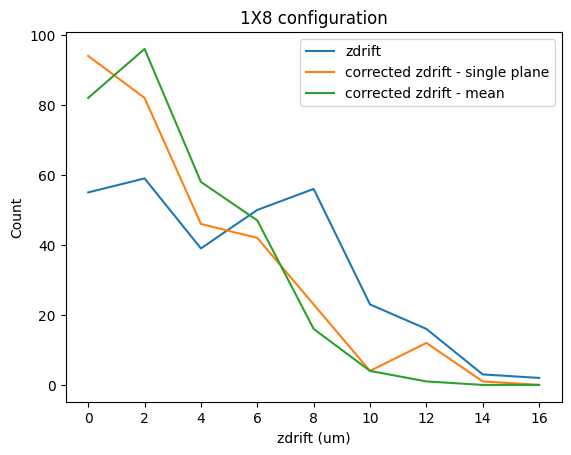

In [60]:
zdrift_all = np.concatenate(zdrift)
corrected_zdrift_single_plane_all = np.concatenate(corrected_zdrift_single_plane)
corrected_zdrift_mean_all = np.concatenate(corrected_zdrift_mean)

bins = np.arange(0,20,2)
fig, ax = plt.subplots()
ax.plot(bins[:-1], np.histogram(abs(zdrift_all), bins=bins)[0], label='zdrift')
ax.plot(bins[:-1], np.histogram(abs(corrected_zdrift_single_plane_all), bins=bins)[0], label='corrected zdrift - single plane')
ax.plot(bins[:-1], np.histogram(abs(corrected_zdrift_mean_all), bins=bins)[0], label='corrected zdrift - mean')

ax.legend()
ax.set_xlabel('zdrift (um)')
ax.set_ylabel('Count')
ax.set_title('1X8 configuration')

In [61]:
threshold_list = range(5,11)
prop_fail_list = []
prop_corrected_fail_single_plane_list = []
prop_corrected_fail_mean_list = []
for threshold in threshold_list:
    prop_fail = np.sum(abs(zdrift_all) > threshold) / len(zdrift_all)
    prop_corrected_fail_single_plane = np.sum(abs(corrected_zdrift_single_plane_all) > threshold) / len(corrected_zdrift_single_plane_all)
    prop_corrected_fail_mean = np.sum(abs(corrected_zdrift_mean_all) > threshold) / len(corrected_zdrift_mean_all)
    prop_fail_list.append(prop_fail)
    prop_corrected_fail_single_plane_list.append(prop_corrected_fail_single_plane)
    prop_corrected_fail_mean_list.append(prop_corrected_fail_mean)

Text(0.5, 1.0, '1X8 configuration')

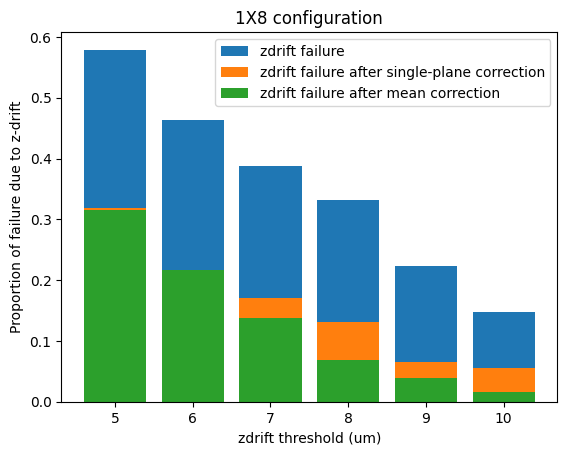

In [62]:
fig, ax = plt.subplots()
ax.bar(threshold_list, prop_fail_list, label='zdrift failure')
ax.bar(threshold_list, prop_corrected_fail_single_plane_list, label='zdrift failure after single-plane correction')
ax.bar(threshold_list, prop_corrected_fail_mean_list, label='zdrift failure after mean correction')
ax.legend()
ax.set_xlabel('zdrift threshold (um)')
ax.set_ylabel('Proportion of failure due to z-drift')
ax.set_title('1X8 configuration')

In [64]:
print(prop_fail_list[-1])
print(prop_corrected_fail_single_plane_list[-1])
print(prop_corrected_fail_mean_list[-1])

0.14802631578947367
0.05592105263157895
0.01644736842105263


In [74]:
len(zdrift_run_table)

2909

In [75]:
len(zdrift_test_table)

346

In [76]:
zdrift_run_table.query('ophys_session_id in @osids').full_genotype.unique()

array(['Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT2L-GC7s-ICF-IRES-tTA2)-hyg/wt'],
      dtype=object)